<a href="https://colab.research.google.com/github/MarcoXM/Audiotest/blob/master/audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi # Showing the Colab notebook info
from google.colab import drive
drive.mount('/content/drive/')

Mon Jun 24 20:24:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Setting the working directory!

In [0]:
import os
os.chdir('/content/drive/My Drive/Audio') 
cwd = os.getcwd()
cwd

'/content/drive/My Drive/Audio'

In [0]:
import pandas as pd
import torch 
import numpy as np
import matplotlib.pyplot as plt 
import librosa
import librosa.display
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras
import warnings
warnings.filterwarnings('ignore')


## Extracting music and features
Dataset
We use [Urban Sound Classification](https://www.kaggle.com/pavansanagapati/urban-sound-classification)

10 classes of audie files 

In [0]:
#testing loading the audio by Librosa
%notebook inline
data, samplerate = librosa.load('Train/224.wav') 
samplerate  #default sampling rate is 22050

22050

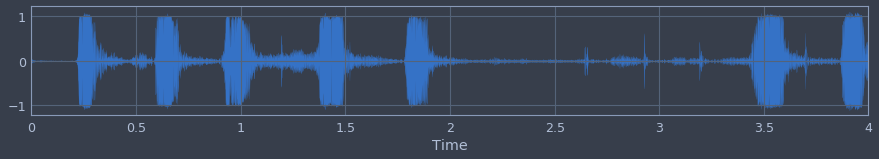

In [0]:
# Plot the graph of the audie file
plt.figure(figsize=(15,2))
librosa.display.waveplot(data,sr= samplerate)

## Exploring the features of an audio file :

> typicallly when we using a collection of measurements to define a audio:

> 1. [Zero Crossing Rate ](https://en.wikipedia.org/wiki/Zero-crossing_rate) : The zero crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back. 
> 2. [Spectral Centroid](https://en.wikipedia.org/wiki/Spectral_centroid): It indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound.
> 3. [Spectral Rolloff]() It is a measure of the shape of the signal. It represents the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies.
> 4.[Mel-frequency cepstrum
](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) : Chroma features are an interesting and powerful representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave.
> 5. [Chroma Frequencies](https://labrosa.ee.columbia.edu/matlab/chroma-ansyn/) : Chroma features are an interesting and powerful representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave.


In [0]:
######################
# Zero Crossing Rate##
######################

zcr = librosa.feature.zero_crossing_rate(data)
zcr.shape

(1, 173)

In [0]:
##################
# Spectral Centroid
spectral_centroids = librosa.feature.spectral_centroid(data, sr=samplerate)
spectral_centroids.shape

(1, 173)

In [0]:
#################
#Spectral Rolloff
spectral_rolloff = librosa.feature.spectral_rolloff(data+0.01, sr=samplerate)
spectral_rolloff.shape

(1, 173)

In [0]:
#################
##Chroma Frequencies
mfccs = librosa.feature.mfcc(data, sr=samplerate) # default 20 
mfccs.shape

(20, 173)

In [0]:
#################
##Chroma Frequencies
chromagram = librosa.feature.chroma_stft(data, sr=samplerate)
chromagram.shape

(12, 173)

In [0]:
###### concat these 5 kinds of data 
audio_representation = np.vstack([zcr,spectral_centroids,spectral_rolloff,mfccs,chromagram])
audio_representation.shape 

(35, 173)

Finailly for each song, we can transform into a matrix , the first dimension of audio features ,the second one is the timesteps!! 

So we have to make sure we have a same time step!

## Transform audio files into numeric data with same time step 

In [0]:
def path2tensor(filename,test = False):
    
    if test:
        df = pd.read_csv(filename)
        classes = list(df.Class)[:10]
        fileslist = [os.path.join('Train/' + str(x) +'.wav') for x in list(df.ID)][:10]
        data_and_sample = [(librosa.load(name))for name in fileslist]
        
        tensor = []
        labels =[]
        n = -1
        for x,y in data_and_sample:
            n += 1
            mat = np.vstack([librosa.feature.zero_crossing_rate(x),
                                librosa.feature.spectral_centroid(x, sr=y),
                                librosa.feature.spectral_rolloff(x + 0.01, sr = y),
                                librosa.feature.mfcc(x, sr=y),
                                librosa.feature.chroma_stft(x, sr=y)])
            if mat.shape[1] == 173:
                tensor.append(mat)
                labels.append(classes[n])
       
    else:
        df = pd.read_csv(filename)
        classes = list(df.Class)
        fileslist = [os.path.join('Train/' + str(x) +'.wav') for x in list(df.ID)]
        data_and_sample = [(librosa.load(name))for name in fileslist]
        
        tensor = []
        labels =[]
        n = -1
        for x,y in data_and_sample:
            n += 1
            mat = np.vstack([librosa.feature.zero_crossing_rate(x),
                                librosa.feature.spectral_centroid(x, sr=y),
                                librosa.feature.spectral_rolloff(x + 0.01, sr = y),
                                librosa.feature.mfcc(x, sr=y),
                                librosa.feature.chroma_stft(x, sr=y)])
            if mat.shape[1] == 173:
                tensor.append(mat)
                labels.append(classes[n])
            

    return tensor,labels


In [0]:
# test
Traindata,y = path2tensor('train.csv',test=True)
Traindata[2],y[2] 

(array([[4.98046875e-02, 6.93359375e-02, 9.66796875e-02, ...,
         4.21875000e-01, 3.39843750e-01, 2.39257812e-01],
        [2.79472499e+03, 2.46965673e+03, 2.40275029e+03, ...,
         4.81767291e+03, 4.73581813e+03, 4.61631352e+03],
        [3.97287598e+03, 3.43454590e+03, 3.47761230e+03, ...,
         8.89321289e+03, 8.71018066e+03, 8.43024902e+03],
        ...,
        [6.37821517e-01, 1.28877844e-01, 5.39348678e-02, ...,
         9.74874114e-01, 9.94544078e-01, 1.00000000e+00],
        [5.68512071e-01, 1.39460635e-01, 6.20144821e-02, ...,
         9.57815576e-01, 9.52742490e-01, 6.40289450e-01],
        [4.14784508e-01, 1.19281488e-01, 6.26671375e-02, ...,
         6.24958883e-01, 6.07631914e-01, 4.15017165e-01]]), 'drilling')

In [0]:
Traindata[2].shape # One Audio file has been transform into a time series data with 173 time step, which is suitable for RNN model

(35, 173)